## Supervised Machine Learning Techniques Assignment I --Yidan Li yl4357

## Table of Content
* [1.Data Preparation](#1)
 * [Drop highly missing/ single value/ not meaningful variables](#1.1)
 * [Binning and encoding missing and special values](#1.2)
 * [Encoding categorical and string variables](#1.3)
* [2.Define functions](#2)
* [3.GBM with h2o](#3)
 * [GBM on small sample dataset (no resampling)](#3.1)
 * [GBM on entire dataset (no resampling)](#3.2)
 * [GBM on entire dataset (random undersampling)](#3.3)
 * [GBM on entire dataset (random oversampling)](#3.4)
 * [GBM on entire dataset (SMOTE)](#3.5)
 * [GBM on entire dataset (ADASYN)](#3.6)
 * [GBM on entire dataset (TomekLinks)](#3.7)
* [4.Deep Learning with Keras](#4)
 * [model 1](#4.1)
 * [model 2](#4.2)
 * [model 3](#4.3)
 * [model 4](#4.4)

In [119]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns

In [120]:
df=pd.read_csv('/Users/liyidan/Desktop/Anomaly Detection/8. Supervised Learning/XYZloan_default_selected_vars.csv')
print(df.head(3))
print(df['loan_default'].value_counts())

   Unnamed: 0  Unnamed: 0.1  id  loan_default  AP001  AP002  AP003  AP004  \
0           0             1   1             1     31      2      1     12   
1           1             2   2             0     27      1      1     12   
2           2             3   3             0     33      1      4     12   

            AP005 AP006  AP007  AP008  AP009  TD001  TD002  TD005  TD006  \
0  2017/7/6 10:21   ios      3      3      1      1      1      4      1   
1  2017/4/6 12:51    h5      5      4      0      2      0      3      1   
2  2017/7/1 14:11    h5      4      2      0      2      1      4      1   

   TD009  TD010  TD013  TD014  TD015  TD022  TD023  TD024  TD025  TD026  \
0      5      1     14      2      2   10.0    9.0    6.0    0.0    0.0   
1      3      1      3      2      0   15.0    6.0    0.0    0.0    0.0   
2      5      1      9      1      2   15.0    9.0    2.0    0.0    0.0   

   TD027  TD028  TD029  TD044  TD048  TD051  TD054  TD055  TD061  TD062  \
0    0.0  

### 1. Data Preparation <a class="anchor" id="1"></a>

Explore the columns with missing value and their data types

In [121]:
null_cols=df.columns[df.isnull().any()]
print(null_cols)  #columns with NA values
print(df.select_dtypes(include=['float64','int64']).columns)  #numeric columns
print(df.select_dtypes(include=['object']).columns)  #categorical columns
#all columns with NA values are numeric

Index(['TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'PA022',
       'PA023', 'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113',
       'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130',
       'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153',
       'CD160', 'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172',
       'CD173', 'MB005'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'loan_default', 'AP001', 'AP002',
       'AP003', 'AP004', 'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 'TD005',
       'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023',
       'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029', 'TD044', 'TD048',
       'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'CR004', 'CR005', 'CR009',
      

#### Drop highly missing/ single value/ not meaningful variables <a class="anchor" id="1.1"></a>

In [122]:
#drop variables that are not meaningful for prediction
df=df.drop(['id','Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [123]:
#drop variables with only 1 unique value (including all missing variables)
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(col,inplace=True,axis=1)

In [124]:
#further examine columns with missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent =100*df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(1)

        print ("The selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

The selected dataframe has 73 columns.
There are 46 columns that have missing values.


,Missing Values,% of Missing Values
TD022,19598,24.5
TD023,7663,9.6
TD024,3694,4.6
MB005,2793,3.5
PA023,381,0.5
CD153,381,0.5
CD130,381,0.5
CD131,381,0.5
CD132,381,0.5
CD133,381,0.5


In [125]:
pd.options.display.max_columns = 100
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,60402.000000,72337.000000,76306.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,7.961900e+04,7.961900e+04,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,77207.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,3.593037,1.345700,5.40600,2.020812,6.804737,2.603662,0.718775,17.120294,7.293156,5.541687,2.503450,1.595638,3.518711e+04,4.924750,5.234962,4.361112,6.199038,19.298811,14.828822,-36.738300,-42.407356,-74.438095,-48.404044,13470.599066,426.021427,34.502167,30.631106,40.050993,4.812457,0.586883,9.460857,3.010374,2.331253,-0.594243,1.176352,68.37697,48.368995,115.663070,83.749532,155.066228,113.074379,88.081815,81.524159,99.278916,108.111493,130.041146,120.280850,143.578153,1.360805e+04,1.366809e+04,6.911956,14.271694,11.773358,909.089313,810.786219,1732.693314,1539.33443,2513.226491,2229.606137,5.976272
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,2.799570,1.413362,4.02311,1.973988,5.128183,2.505840,0.882962,7.024737,7.395779,6.157043,1.117991,1.083602,6.359684e+04,1.094305,2.398870,2.498607,3.359354,39.705478,37.009374,100.731779,97.006168,74.146246,96.313406,13058.772406,373.327926,66.483870,61.899563,78.969397,43.655893,29.029802,61.423633,37.172491,35.030955,21.642171,23.311023,60.57446,46.932544,91.713711,69.112448,116.368152,86.765922,90.320004,88.529928,96.068148,96.793174,123.525977,120.935487,130.487618,1.905389e+04,1.935326e+04,28.007499,38.235012,33.270641,1379.553332,1245.044602,2441.503517,2172.71384,3404.975112,3005.615048,3.641814
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,2.000000,1.000000,0.000000,1.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-9.900000e+01,-9.900000e+01,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,0.000000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,3.00000,1.000000,3.000000,1.000000,0.000000,10.000000,3.000000,2.000000,2.000000,1.000000,4.700000e+03,5.000000,3.000000,2.000000,3.000000,-1.000000,-1.000000,-98.000000,-98.000000,-98.000000,-98.000000,4769.500000,163.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.00000,28.000000,65.000000,48.000000,88.000000,65.000000,31.000000,26.000000,40.000000,48.000000

According to the variable description, variable PA022-CD173 should all be positive, but they all have negative values inside as shown in the above statistics, like -99, -1, which should be put in a new category, these variables will be included in the same category with NA values.

#### Binning and encoding missing and special values <a class="anchor" id="1.2"></a>

In [126]:
var_with_na=df.columns[df.isnull().any()]
var_with_na

Index(['TD022', 'TD023', 'TD024', 'PA022', 'PA023', 'PA028', 'PA029', 'PA030',
       'PA031', 'CD008', 'CD018', 'CD071', 'CD072', 'CD088', 'CD100', 'CD101',
       'CD106', 'CD107', 'CD108', 'CD113', 'CD114', 'CD115', 'CD117', 'CD118',
       'CD120', 'CD121', 'CD123', 'CD130', 'CD131', 'CD132', 'CD133', 'CD135',
       'CD136', 'CD137', 'CD152', 'CD153', 'CD160', 'CD162', 'CD164', 'CD166',
       'CD167', 'CD169', 'CD170', 'CD172', 'CD173', 'MB005'],
      dtype='object')

In [127]:
def binning(var):
    df[var].loc[df[var]==-99]=float('NaN')
    df[var].loc[df[var]==-98]=float('NaN')
    df[var].loc[df[var]==-1]=float('NaN')#convert all negative values to NA values
    df[var + '_bin'] = pd.qcut(df[var],10,duplicates='drop').values.add_categories("NoData")
    df[var + '_bin'] = df[var + '_bin'].fillna("NoData").astype('category') #assign NA values the category 'NoData'

import warnings
warnings.filterwarnings("ignore")   
    
for i in var_with_na:
    binning(i)

In [128]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,CD172,CD173,MB005,MB007,TD022_bin,TD023_bin,TD024_bin,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin
0,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,2249.0,2249.0,7.0,IPHONE7,"(9.999, 15.0]","(6.0, 9.0]","(4.0, 6.0]",NoData,NoData,NoData,NoData,NoData,NoData,"(13171.0, 16592.0]","(152.0, 214.0]","(-0.001, 3.0]","(-0.001, 3.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(55.0, 65.0]","(47.0, 55.0]","(92.0, 107.0]","(68.0, 79.0]","(123.0, 144.0]","(91.0, 106.0]","(28.0, 43.0]","(52.0, 67.0]","(52.0, 68.0]","(45.0, 61.0]","(44.0, 66.0]","(77.0, 100.0]","(77.0, 99.0]","(9081.0, 11685.0]","(12444.0, 15706.0]","(7.0, 9.0]","(10.0, 13.0]","(11.0, 14.0]","(-0.001, 64.0]","(-0.001, 8.0]","(1098.0, 1498.0]","(1306.0, 1793.0]","(2216.0, 2936.7]","(1930.0, 2606.0]","(6.0, 7.0]"
1,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WEB,"(9.999, 15.0]","(3.0, 6.0]","(-0.001, 2.0]",NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData,NoData
2,0,33,1,4,12,2017/7/1 14:11,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,143.0,110.0,8.0,WEB,"(9.999, 15.0]","(6.0, 9.0]","(-0.001, 2.0]",NoData,NoData,NoData,NoData,NoData,NoData,"(-0.001, 2536.0]","(-0.001, 89.0]","(-0.001, 3.0]","(-0.001, 3.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 1.0]","(-0.001, 26.0]","(-0.001, 19.0]","(-0.001, 45.0]","(-0.001, 33.0]","(-0.001, 62.0]","(-0.001, 45.0]","(-0.001, 12.0]","(-0.001, 10.0]","(-0.001, 22.0]","(-0.001, 27.0]","(-0.001, 21.0]","(-0.001, 18.0]","(-0.001, 32.0]","(3604.0, 5189.0]","(-0.001, 2558.1]","(-0.001, 1.0]","(2.0, 5.0]","(1.0, 4.0]","(-0.001, 64.0]","(-0.001, 8.0]","(-0.001, 68.0]","(-0.001, 7.0]","(-0.001, 172.0]","(105.0, 366.0]","(7.0, 9.0]"


#### Encode the binned variables using LabelEncoder

In [129]:
from sklearn.preprocessing import LabelEncoder
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
filter_col = [col for col in df if col.endswith('bin')]
filter_col
for var in filter_col:
    df[var]=df[var].astype(str)
    df[var]=labelencoder.fit_transform(df[var])

In [130]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,CD172,CD173,MB005,MB007,TD022_bin,TD023_bin,TD024_bin,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin
0,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,2249.0,2249.0,7.0,IPHONE7,3,4,4,10,10,10,10,10,10,2,1,0,0,0,0,0,0,0,0,0,0,6,6,9,7,2,9,5,7,7,6,7,9,8,9,1,8,1,2,0,0,1,1,4,4,6
1,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,WEB,3,3,0,10,10,10,10,10,10,10,10,8,8,9,7,5,8,6,6,6,7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9,10,10,10,10,9
2,0,33,1,4,12,2017/7/1 14:11,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,143.0,110.0,8.0,WEB,3,4,0,10,10,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,4,1,0,0,0,0,0,2,7


#### Encoding categorical and string variables (AP002, AP005, AP006, MB007)  <a class="anchor" id="1.3"></a>

In [131]:
#extract year, month, day, hour, weekday from AP005
from datetime import datetime
df['AP005'] = pd.to_datetime(df['AP005'])
df['year'] = pd.DatetimeIndex(df['AP005']).year
df['month'] = pd.DatetimeIndex(df['AP005']).month
df['day'] = pd.DatetimeIndex(df['AP005']).day
df['hour'] = pd.DatetimeIndex(df['AP005']).hour
df['weekday'] = pd.DatetimeIndex(df['AP005']).dayofweek
#encoding
df['year'] =labelencoder.fit_transform(df['year'])
df['month'] = labelencoder.fit_transform(df['month'])
df['day'] = labelencoder.fit_transform(df['day'])
df['hour'] =labelencoder.fit_transform(df['hour'])
df['weekday'] = labelencoder.fit_transform(df['weekday'])

In [132]:
#age data
df['AP001'].isnull().sum()
binning('AP001')
df['AP001_bin']=labelencoder.fit_transform(df['AP001_bin'])
#gender data
df['AP002']=labelencoder.fit_transform(df['AP002'])

In [133]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,...,TD024_bin,PA022_bin,PA023_bin,PA028_bin,PA029_bin,PA030_bin,PA031_bin,CD008_bin,CD018_bin,CD071_bin,CD072_bin,CD088_bin,CD100_bin,CD101_bin,CD106_bin,CD107_bin,CD108_bin,CD113_bin,CD114_bin,CD115_bin,CD117_bin,CD118_bin,CD120_bin,CD121_bin,CD123_bin,CD130_bin,CD131_bin,CD132_bin,CD133_bin,CD135_bin,CD136_bin,CD137_bin,CD152_bin,CD153_bin,CD160_bin,CD162_bin,CD164_bin,CD166_bin,CD167_bin,CD169_bin,CD170_bin,CD172_bin,CD173_bin,MB005_bin,year,month,day,hour,weekday,AP001_bin
0,1,31.0,1,1,12,2017-07-06 10:21:00,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,NaN,NaN,NaN,NaN,NaN,NaN,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,...,4,10,10,10,10,10,10,2,1,0,0,0,0,0,0,0,0,0,0,6,6,9,7,2,9,5,7,7,6,7,9,8,9,1,8,1,2,0,0,1,1,4,4,6,0,4,5,10,3,5
1,0,27.0,0,1,12,2017-04-06 12:51:00,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,10,10,10,10,10,10,10,10,8,8,9,7,5,8,6,6,6,7,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,9,9,10,10,10,10,9,0,1,5,12,3,2
2,0,33.0,0,4,12,2017-07-01 14:11:00,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,...,0,10,10,10,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,4,1,0,0,0,0,0,2,7,0,4,0,14,5,6


#### encoding categorical variables

In [134]:
#encode categorical variables ---AP006
print(df['AP006'].nunique())  #4 categories 
print(df.AP006.isna().sum()) #no missing value
df['AP006'] =labelencoder.fit_transform(df['AP006'])

4
0


In [135]:
#encode categorical variables  ---MB007
print(df['MB007'].nunique())  #112 categories 
print(df.MB007.isna().sum())  #no missing value
df['MB007'] =labelencoder.fit_transform(df['MB007'])

112
0


In [136]:
df.isnull().sum()

loan_default    0
AP001           0
AP002           0
AP003           0
AP004           0
               ..
month           0
day             0
hour            0
weekday         0
AP001_bin       0
Length: 125, dtype: int64

In [137]:
df.columns.tolist()

['loan_default',
 'AP001',
 'AP002',
 'AP003',
 'AP004',
 'AP005',
 'AP006',
 'AP007',
 'AP008',
 'AP009',
 'TD001',
 'TD002',
 'TD005',
 'TD006',
 'TD009',
 'TD010',
 'TD013',
 'TD014',
 'TD015',
 'TD022',
 'TD023',
 'TD024',
 'CR004',
 'CR005',
 'CR009',
 'CR015',
 'CR017',
 'CR018',
 'CR019',
 'PA022',
 'PA023',
 'PA028',
 'PA029',
 'PA030',
 'PA031',
 'CD008',
 'CD018',
 'CD071',
 'CD072',
 'CD088',
 'CD100',
 'CD101',
 'CD106',
 'CD107',
 'CD108',
 'CD113',
 'CD114',
 'CD115',
 'CD117',
 'CD118',
 'CD120',
 'CD121',
 'CD123',
 'CD130',
 'CD131',
 'CD132',
 'CD133',
 'CD135',
 'CD136',
 'CD137',
 'CD152',
 'CD153',
 'CD160',
 'CD162',
 'CD164',
 'CD166',
 'CD167',
 'CD169',
 'CD170',
 'CD172',
 'CD173',
 'MB005',
 'MB007',
 'TD022_bin',
 'TD023_bin',
 'TD024_bin',
 'PA022_bin',
 'PA023_bin',
 'PA028_bin',
 'PA029_bin',
 'PA030_bin',
 'PA031_bin',
 'CD008_bin',
 'CD018_bin',
 'CD071_bin',
 'CD072_bin',
 'CD088_bin',
 'CD100_bin',
 'CD101_bin',
 'CD106_bin',
 'CD107_bin',
 'CD108_bin

In [138]:
df1=df[['loan_default','AP002','AP003','AP004','AP006','AP007','AP008','AP009','TD001','TD002',
 'TD005','TD006','TD009','TD010','TD013','TD014','TD015','CR004','CR005','CR009',
 'CR015','CR017','CR018','CR019','MB007','TD022_bin','TD023_bin','TD024_bin','PA022_bin',
 'PA023_bin', 'PA028_bin','PA029_bin','PA030_bin','PA031_bin','CD008_bin','CD018_bin','CD071_bin',
'CD072_bin','CD088_bin','CD100_bin','CD101_bin','CD106_bin','CD107_bin','CD108_bin','CD113_bin',
 'CD114_bin','CD115_bin','CD117_bin','CD118_bin','CD120_bin','CD121_bin','CD123_bin','CD130_bin',
 'CD131_bin','CD132_bin','CD133_bin','CD135_bin','CD136_bin','CD137_bin','CD152_bin','CD153_bin',
 'CD160_bin','CD162_bin','CD164_bin','CD166_bin','CD167_bin','CD169_bin','CD170_bin','CD172_bin',
 'CD173_bin','MB005_bin','AP001_bin','year','month','day','hour','weekday']]

In [139]:
df1.shape

(80000, 77)

In [140]:
#End of data preparation

### 2. Define Functions  <a class="anchor" id="2"></a>

#### Feature Importance Plot

In [141]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

#### Gains Table

In [142]:
def createGains(model,test_data):
    predictions = model.predict(test_data)
    test_scores = test_data['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

#### ROC and PR Curves

In [143]:
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
#     print(y_pred[['p1']])
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

### GBM with h2o <a class="anchor" id="3"></a>

In [144]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 hours 43 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_liyidan_xwqjdc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [145]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     df1,stratify=df1['loan_default'], test_size=0.30, random_state=1)

#### GBM on small sample (no resampling) <a class="anchor" id="3.1"></a>

In [78]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex1 = h2o.H2OFrame(train_smpl)
test_hex1 = h2o.H2OFrame(test_smpl)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [79]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [84]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
gbm_v1 = H2OGradientBoostingEstimator(model_id='gbm_v1',ntrees=300,nfolds=10, 
                                      max_depth=5, min_rows=10,learn_rate=0.05,seed=1234)
gbm_v1.train(predictors,target,training_frame=train_hex1)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


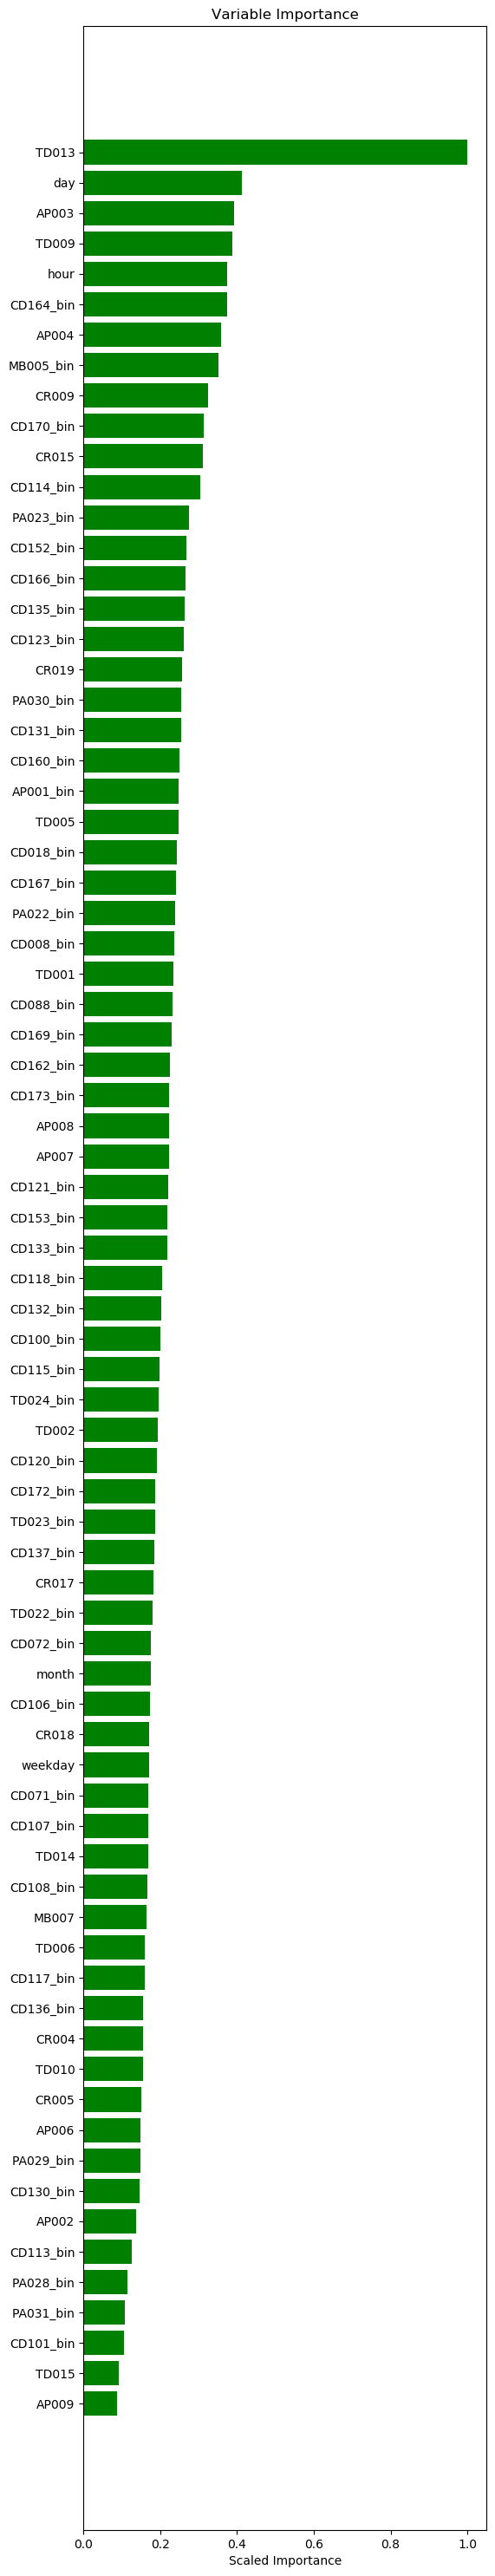

In [85]:
VarImp(gbm_v1)

In [86]:
predictions = gbm_v1.predict(test_hex1)
print(predictions)
test_scores = test_hex1['loan_default'].cbind(predictions).as_data_frame()
print(test_scores)

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict
0.253105
0.407222
0.224951
0.116153
0.144308
0.119044
0.15374
-0.0491505
0.0803001
0.0136366



      loan_default   predict
0                0  0.253105
1                1  0.407222
2                0  0.224951
3                0  0.116153
4                0  0.144308
...            ...       ...
2395             0  0.421832
2396             0  0.350279
2397             0  0.351648
2398             1  0.173680
2399             0  0.083868

[2400 rows x 2 columns]


#### Gains Table

In [87]:
createGains(gbm_v1,test_hex1)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,240,72,168,240,72,168,0.16,0.09,45.9,1.57,7.0,30.00
1,240,65,175,480,137,343,0.30,0.18,91.8,1.49,12.0,28.54
2,240,68,172,720,205,515,0.45,0.27,137.7,1.49,18.0,28.47
3,240,49,191,960,254,706,0.55,0.36,183.6,1.38,19.0,26.46
4,240,43,197,1200,297,903,0.65,0.47,229.5,1.29,18.0,24.75
5,240,46,194,1440,343,1097,0.75,0.57,275.4,1.25,18.0,23.82
6,240,32,208,1680,375,1305,0.82,0.67,321.3,1.17,15.0,22.32
7,240,30,210,1920,405,1515,0.88,0.78,367.2,1.10,10.0,21.09
8,240,31,209,2160,436,1724,0.95,0.89,413.1,1.06,6.0,20.19


#### ROC Curve and PR Curve

gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



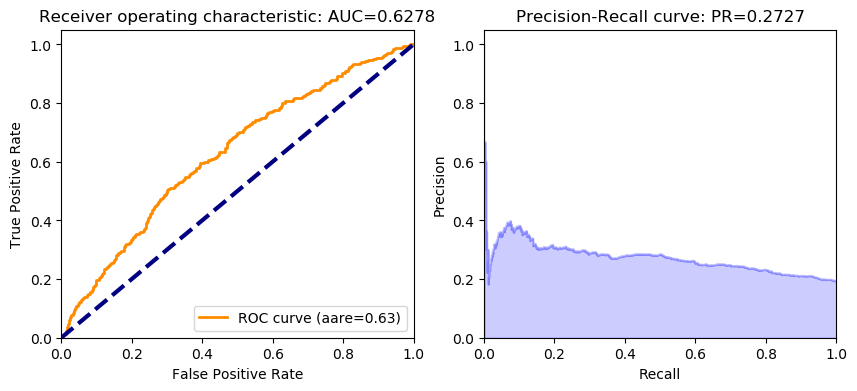

In [88]:
ROC_AUC(gbm_v1,test_hex1,'loan_default')

#### GBM on entire dataset (no resampling) <a class="anchor" id="3.2"></a>

In [89]:
train_hex2 = h2o.H2OFrame(train)
test_hex2 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [65]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [90]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
gbm_v2 = H2OGradientBoostingEstimator(model_id='gbm_v2',ntrees=300,nfolds=10, max_depth=5,
                                       min_rows=10,learn_rate=0.05,seed=1234)
gbm_v2.train(predictors,target,training_frame=train_hex2)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


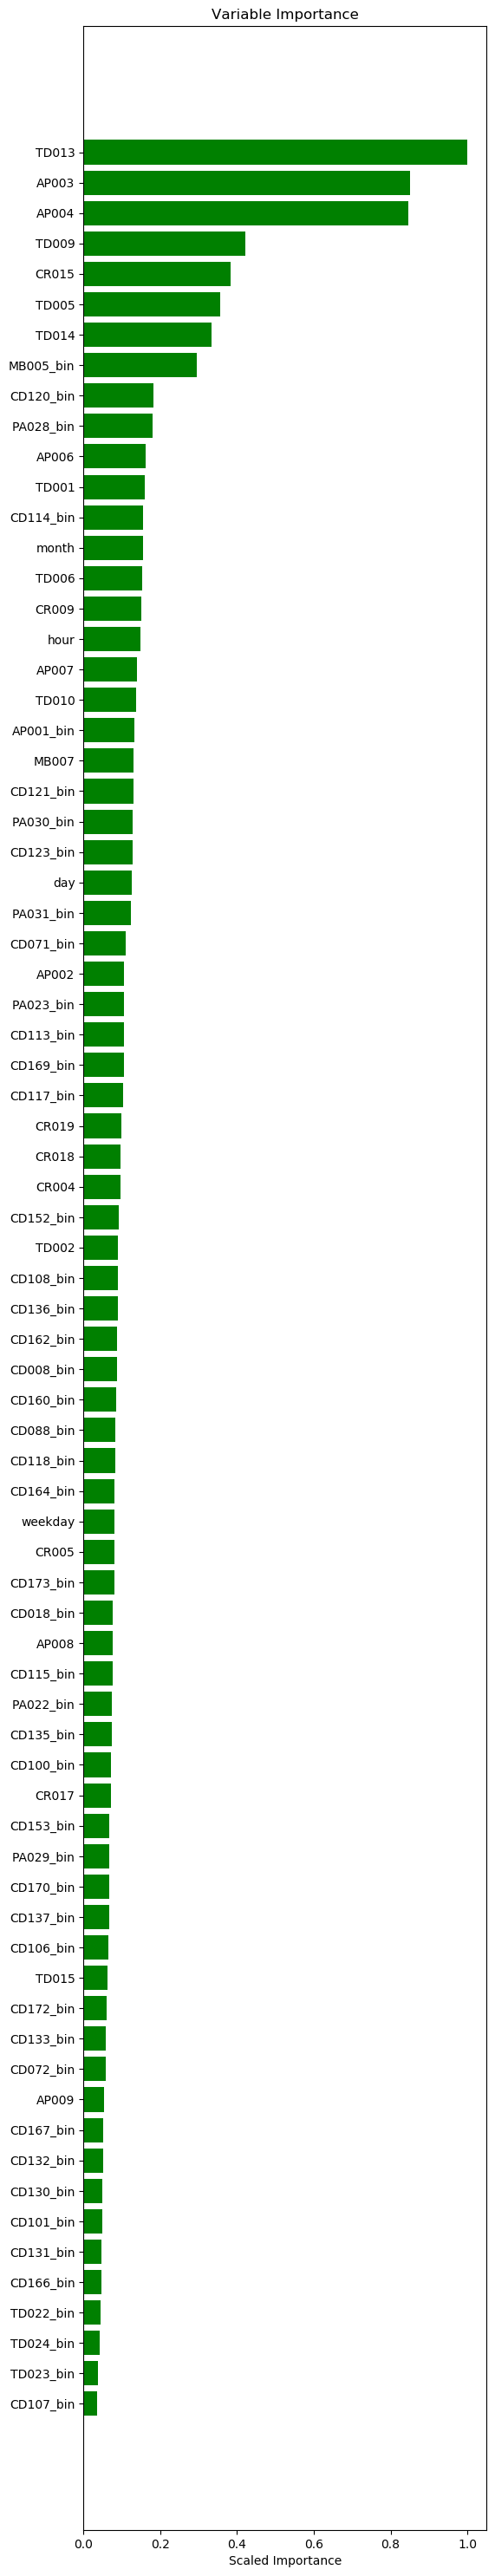

In [91]:
# feature importance
VarImp(gbm_v2)

In [92]:
createGains(gbm_v2,test_hex2)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,939,1461,2400,939,1461,0.20,0.08,464.6,2.02,12.0,39.12
1,2400,759,1641,4800,1698,3102,0.37,0.16,929.2,1.83,21.0,35.38
2,2400,671,1729,7200,2369,4831,0.51,0.25,1393.8,1.70,26.0,32.90
3,2400,495,1905,9600,2864,6736,0.62,0.35,1858.4,1.54,27.0,29.83
4,2400,481,1919,12000,3345,8655,0.72,0.45,2323.0,1.44,27.0,27.88
5,2400,412,1988,14400,3757,10643,0.81,0.55,2787.6,1.35,26.0,26.09
6,2400,301,2099,16800,4058,12742,0.87,0.66,3252.2,1.25,21.0,24.15
7,2400,285,2115,19200,4343,14857,0.93,0.77,3716.8,1.17,16.0,22.62
8,2400,197,2203,21600,4540,17060,0.98,0.88,4181.4,1.09,10.0,21.02


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



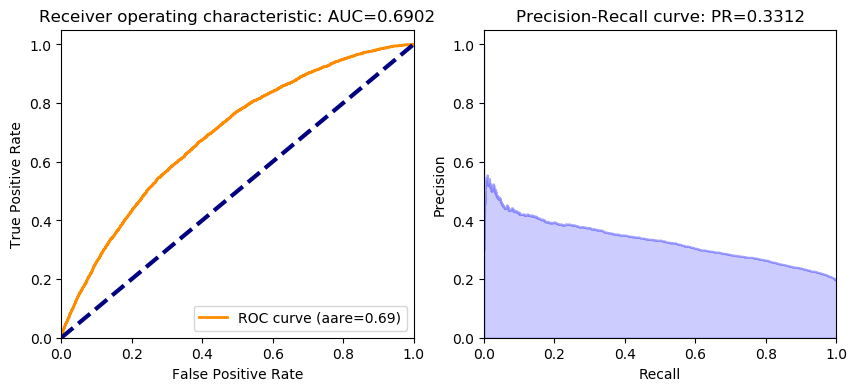

In [93]:
# ROC PR curves
ROC_AUC(gbm_v2,test_hex2,'loan_default')

#### GBM on entire dataset (random undersampling) <a class="anchor" id="3.3"></a>

In [94]:
# define undersampling strategy
from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy=0.5)
X_under, y_under = sampler.fit_sample(train.drop(labels=['loan_default'], axis=1), train[['loan_default']])

In [95]:
train_random_under=pd.concat([X_under,y_under],axis=1)

In [96]:
train_random_under_hex3=h2o.H2OFrame(train_random_under)
test_hex3 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [97]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [98]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
gbm_v3 = H2OGradientBoostingEstimator(model_id='gbm_v3',ntrees=300,nfolds=10, max_depth=5,
                                      min_rows=10,learn_rate=0.05, seed=1234)
gbm_v3.train(predictors,target,training_frame=train_random_under_hex3)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


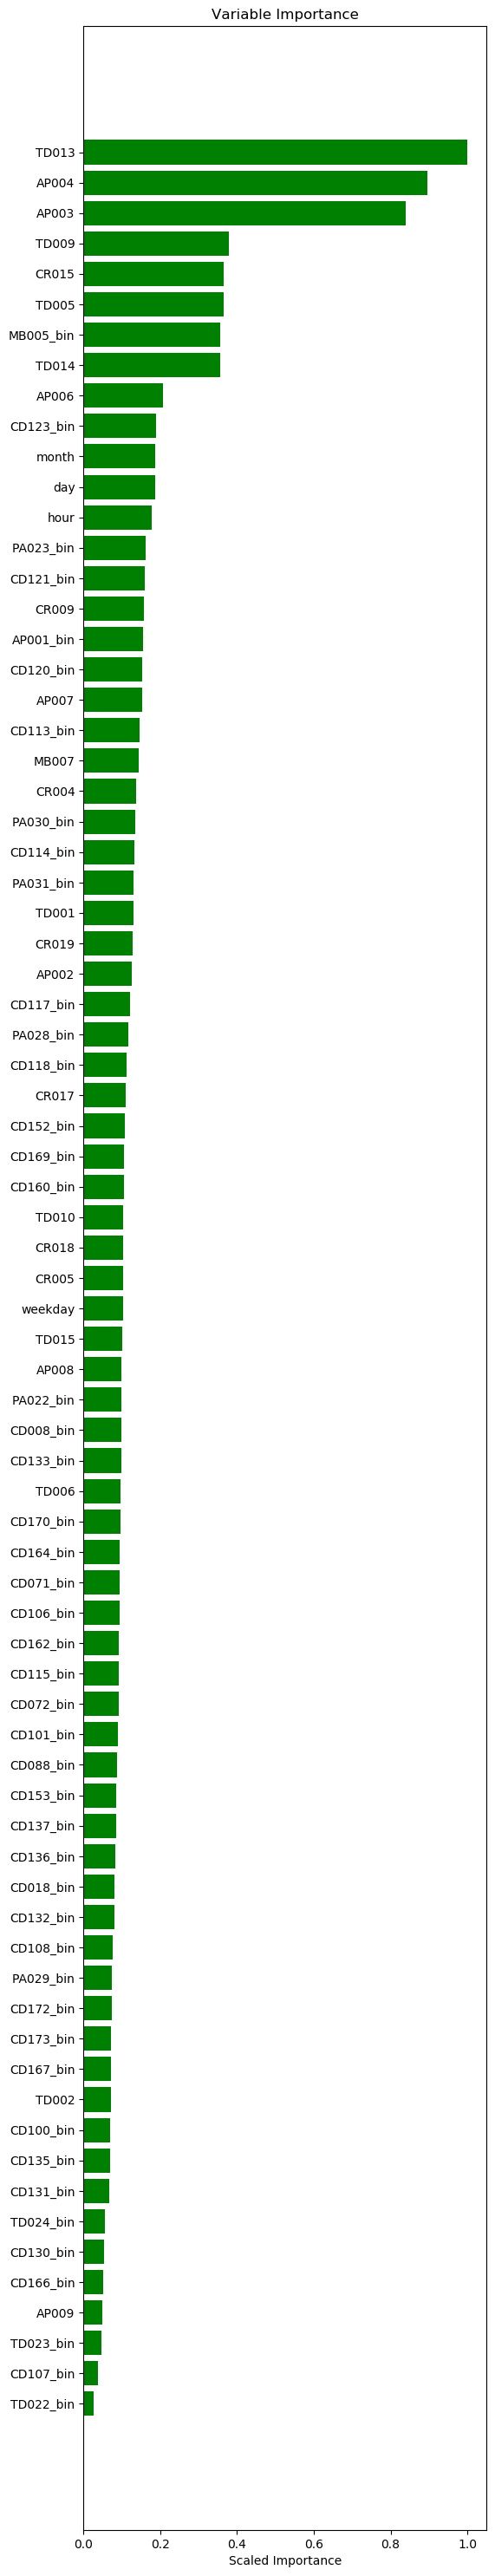

In [99]:
# feature importance
VarImp(gbm_v3)

In [100]:
createGains(gbm_v3,test_hex3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,967,1433,2400,967,1433,0.21,0.07,464.6,2.08,14.0,40.29
1,2400,758,1642,4800,1725,3075,0.37,0.16,929.2,1.86,21.0,35.94
2,2400,610,1790,7200,2335,4865,0.50,0.25,1393.8,1.68,25.0,32.43
3,2400,542,1858,9600,2877,6723,0.62,0.35,1858.4,1.55,27.0,29.97
4,2400,480,1920,12000,3357,8643,0.72,0.45,2323.0,1.45,27.0,27.98
5,2400,389,2011,14400,3746,10654,0.81,0.55,2787.6,1.34,26.0,26.01
6,2400,339,2061,16800,4085,12715,0.88,0.66,3252.2,1.26,22.0,24.32
7,2400,275,2125,19200,4360,14840,0.94,0.77,3716.8,1.17,17.0,22.71
8,2400,189,2211,21600,4549,17051,0.98,0.88,4181.4,1.09,10.0,21.06


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



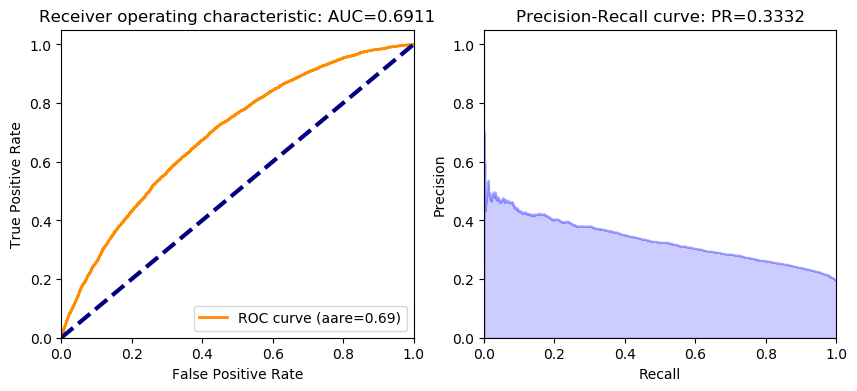

In [101]:
ROC_AUC(gbm_v3,test_hex3,'loan_default')

#### GBM on entire dataset (random oversampling)  <a class="anchor" id="3.4"></a>

In [102]:
# define oversampling strategy
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy=0.5)
X_over, y_over = sampler.fit_sample(train.drop(labels=['loan_default'], axis=1), train[['loan_default']])

In [103]:
train_random_over=pd.concat([X_over,y_over],axis=1)

In [104]:
train_random_over_hex4=h2o.H2OFrame(train_random_over)
test_hex4 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [105]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [106]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_v4 = H2OGradientBoostingEstimator(model_id = 'gbm_v4',ntrees = 300,nfolds=10,max_depth=5,
        min_rows=10,learn_rate=0.05, seed=1234)
gbm_v4.train(predictors,target,training_frame=train_random_over_hex4)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


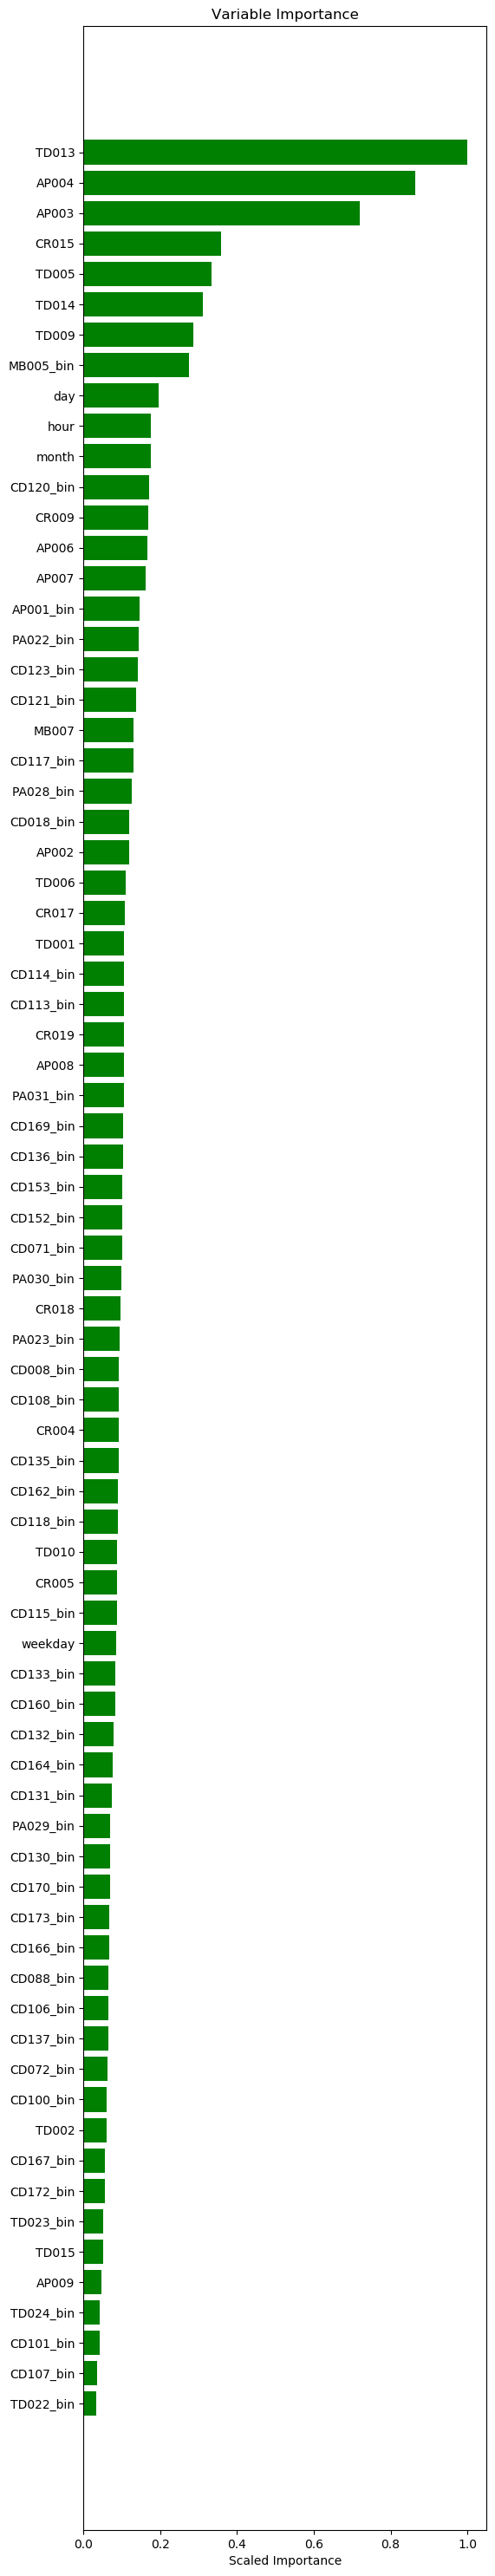

In [107]:
# feature importance
VarImp(gbm_v4)

In [108]:
createGains(gbm_v4,test_hex4)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,943,1457,2400,943,1457,0.20,0.08,464.6,2.03,12.0,39.29
1,2400,775,1625,4800,1718,3082,0.37,0.16,929.2,1.85,21.0,35.79
2,2400,642,1758,7200,2360,4840,0.51,0.25,1393.8,1.69,26.0,32.78
3,2400,532,1868,9600,2892,6708,0.62,0.35,1858.4,1.56,27.0,30.12
4,2400,442,1958,12000,3334,8666,0.72,0.45,2323.0,1.44,27.0,27.78
5,2400,418,1982,14400,3752,10648,0.81,0.55,2787.6,1.35,26.0,26.06
6,2400,311,2089,16800,4063,12737,0.87,0.66,3252.2,1.25,21.0,24.18
7,2400,281,2119,19200,4344,14856,0.93,0.77,3716.8,1.17,16.0,22.62
8,2400,202,2198,21600,4546,17054,0.98,0.88,4181.4,1.09,10.0,21.05


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



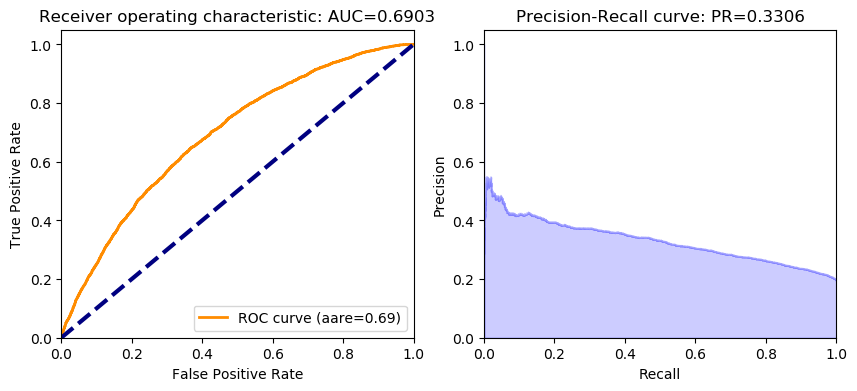

In [109]:
ROC_AUC(gbm_v4,test_hex4,'loan_default')

#### GBM on entire dataset (SMOTE) <a class="anchor" id="3.5"></a>

In [110]:
# define oversampling strategy
from imblearn.over_sampling import SMOTE
sampler = SMOTE(sampling_strategy=0.5)
X_over, y_over = sampler.fit_sample(train.drop(labels=['loan_default'], axis=1), train[['loan_default']])

In [111]:
train_smote_over=pd.concat([X_over,y_over],axis=1)

In [112]:
train_smote_over_hex5=h2o.H2OFrame(train_smote_over)
test_hex5 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [113]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [114]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_v5 = H2OGradientBoostingEstimator(model_id = 'gbm_v5',ntrees = 300,nfolds=10,
         min_rows=10,learn_rate=0.05,max_depth=5,seed=1234)
gbm_v5.train(predictors,target,training_frame=train_smote_over_hex5)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


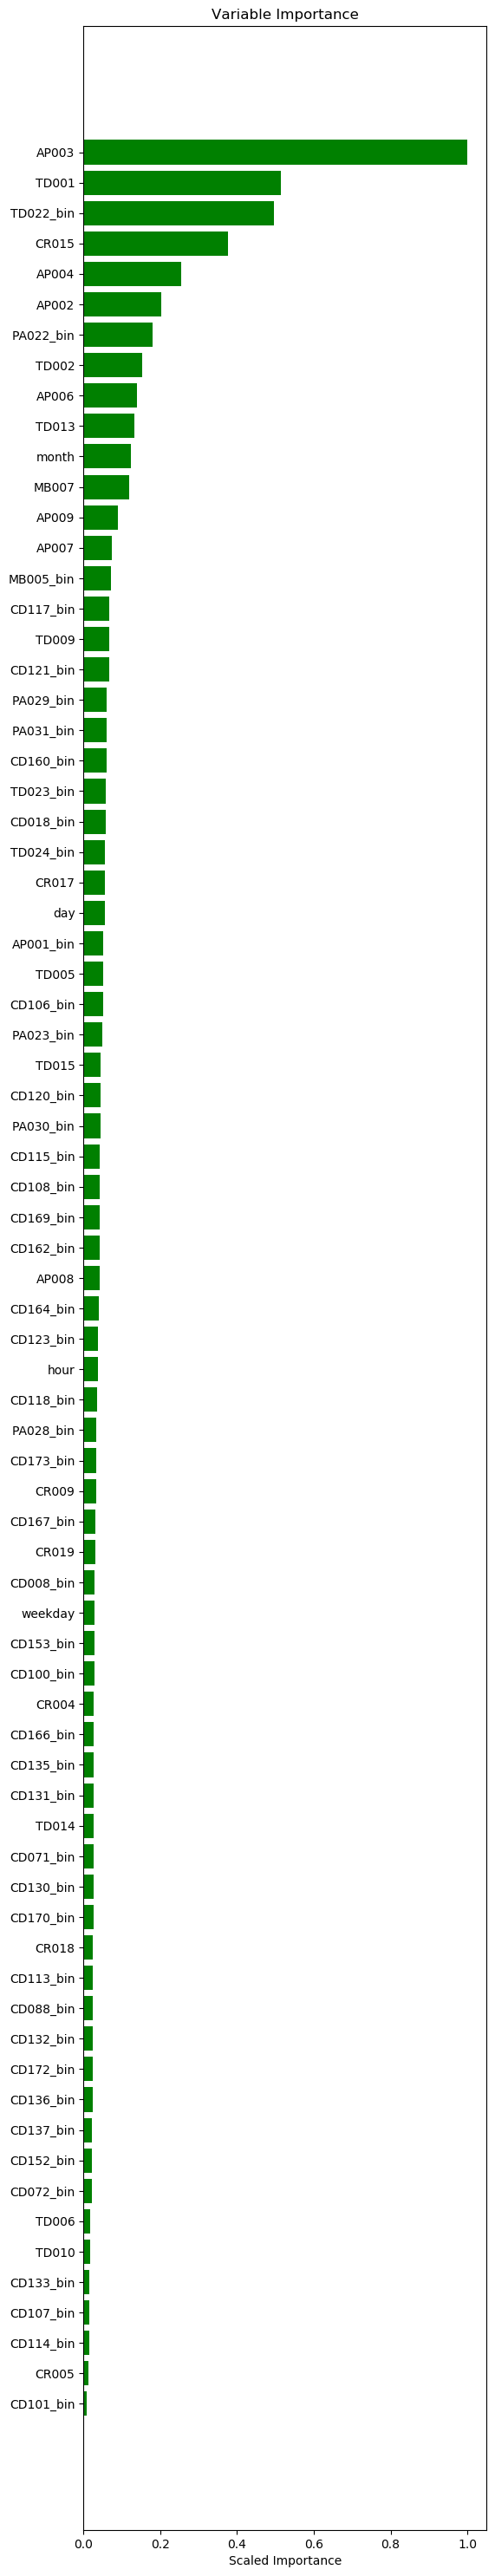

In [99]:
# feature importance
VarImp(gbm_v5)

In [100]:
createGains(gbm_v5,test_hex5)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,876,1524,2400,876,1524,0.19,0.08,464.6,1.89,11.0,36.50
1,2400,721,1679,4800,1597,3203,0.34,0.17,929.2,1.72,17.0,33.27
2,2400,621,1779,7200,2218,4982,0.48,0.26,1393.8,1.59,22.0,30.81
3,2400,529,1871,9600,2747,6853,0.59,0.35,1858.4,1.48,24.0,28.61
4,2400,503,1897,12000,3250,8750,0.70,0.45,2323.0,1.40,25.0,27.08
5,2400,392,2008,14400,3642,10758,0.78,0.56,2787.6,1.31,22.0,25.29
6,2400,353,2047,16800,3995,12805,0.86,0.66,3252.2,1.23,20.0,23.78
7,2400,285,2115,19200,4280,14920,0.92,0.77,3716.8,1.15,15.0,22.29
8,2400,237,2163,21600,4517,17083,0.97,0.88,4181.4,1.08,9.0,20.91


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



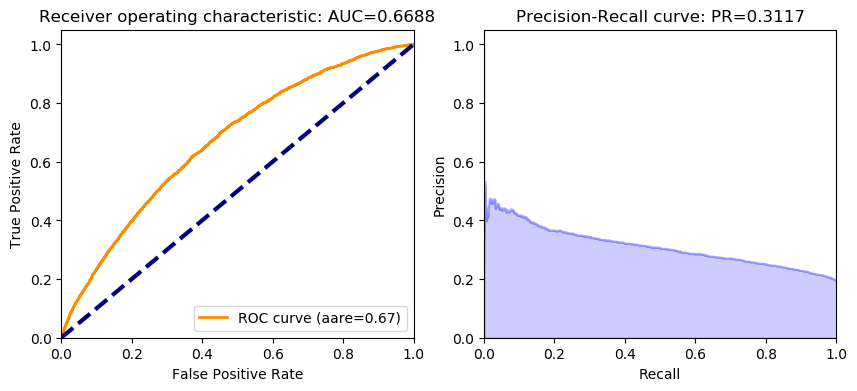

In [101]:
ROC_AUC(gbm_v5,test_hex5,'loan_default')

#### GBM on entire dataset (ADASYN) <a class="anchor" id="3.6"></a>

In [146]:
# define oversampling strategy
from imblearn.over_sampling import ADASYN
sampler = ADASYN(sampling_strategy=0.5)
X_over, y_over = sampler.fit_sample(train.drop(labels=['loan_default'], axis=1), train[['loan_default']])

In [147]:
train_adasyn_over=pd.concat([X_over,y_over],axis=1)

In [148]:
train_adasyn_over_hex6=h2o.H2OFrame(train_adasyn_over)
test_hex6 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [149]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [150]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_v6 = H2OGradientBoostingEstimator( model_id = 'gbm_v6',ntrees = 300,nfolds=10,
        max_depth=5, min_rows=10,learn_rate=0.05,seed=1234)

gbm_v6.train(predictors,target,training_frame=train_adasyn_over_hex6)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


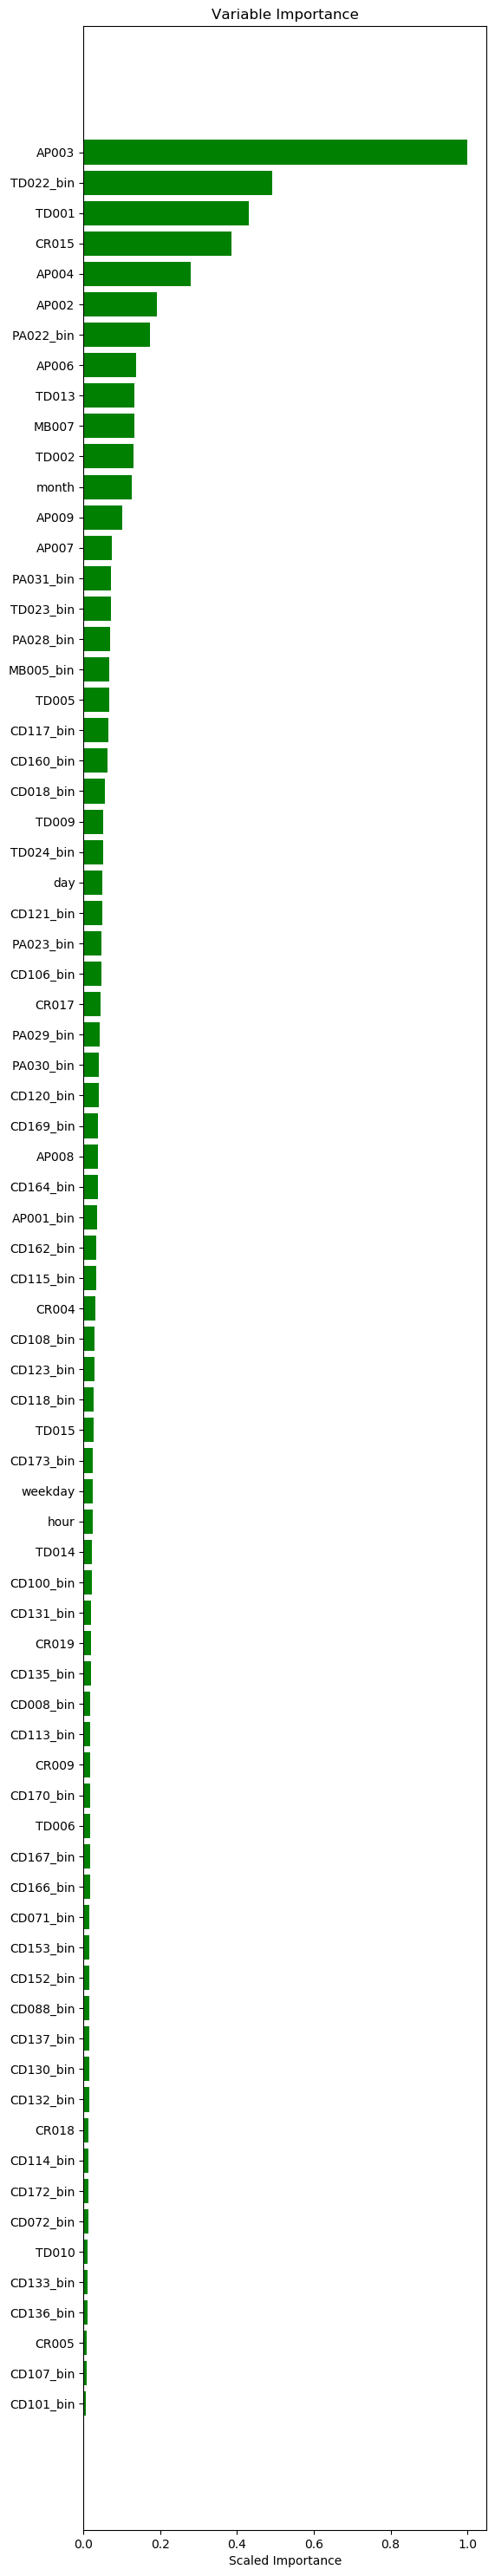

In [151]:
# feature importance
VarImp(gbm_v6)

In [152]:
createGains(gbm_v6,test_hex6)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,894,1506,2400,894,1506,0.19,0.08,464.6,1.92,11.0,37.25
1,2400,709,1691,4800,1603,3197,0.35,0.17,929.2,1.73,18.0,33.40
2,2400,650,1750,7200,2253,4947,0.48,0.26,1393.8,1.62,22.0,31.29
3,2400,547,1853,9600,2800,6800,0.60,0.35,1858.4,1.51,25.0,29.17
4,2400,453,1947,12000,3253,8747,0.70,0.45,2323.0,1.40,25.0,27.11
5,2400,420,1980,14400,3673,10727,0.79,0.55,2787.6,1.32,24.0,25.51
6,2400,323,2077,16800,3996,12804,0.86,0.66,3252.2,1.23,20.0,23.79
7,2400,297,2103,19200,4293,14907,0.92,0.77,3716.8,1.16,15.0,22.36
8,2400,215,2185,21600,4508,17092,0.97,0.88,4181.4,1.08,9.0,20.87


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



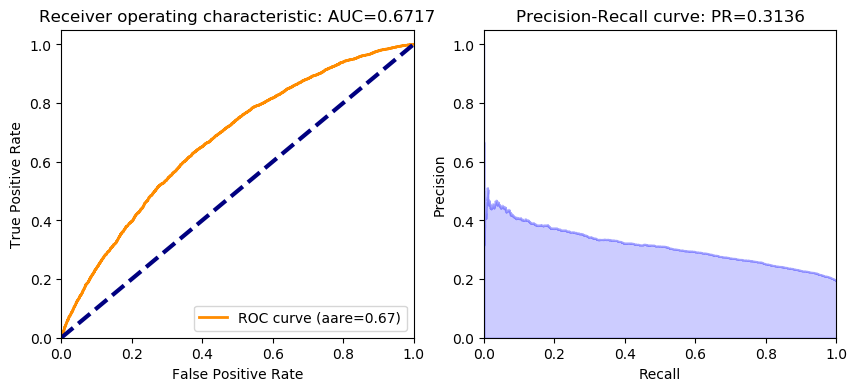

In [153]:
ROC_AUC(gbm_v6,test_hex6,'loan_default')

#### GBM on entire dataset (TomekLinks)<a class="anchor" id="3.7"></a>

In [155]:
from imblearn.under_sampling import TomekLinks
sampler = TomekLinks()
X_under, y_under = sampler.fit_sample(train.drop(labels=['loan_default'], axis=1), train[['loan_default']])

In [156]:
train_tomeklinks_under=pd.concat([X_under,y_under],axis=1)

In [157]:
train_tomeklinks_under_hex7=h2o.H2OFrame(train_random_under)
test_hex7 = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [158]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [159]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
gbm_v7 = H2OGradientBoostingEstimator(model_id='gbm_v7',ntrees=300,nfolds=10, max_depth=5,
                                      min_rows=10,learn_rate=0.05, seed=1234)
gbm_v7.train(predictors,target,training_frame=train_tomeklinks_under_hex7)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


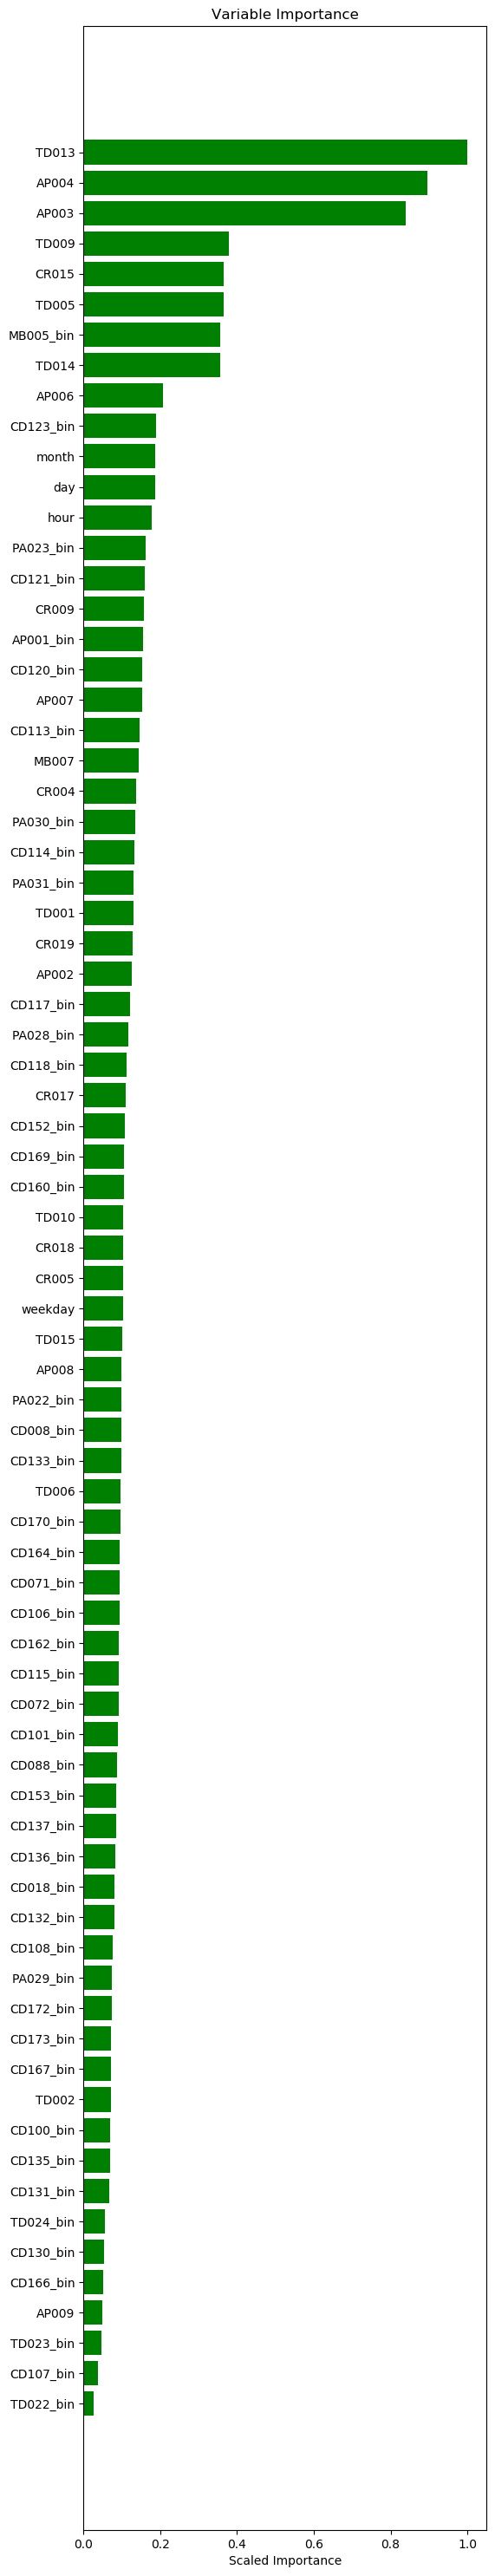

In [160]:
# feature importance
VarImp(gbm_v7)

In [161]:
createGains(gbm_v7,test_hex7)

gbm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,967,1433,2400,967,1433,0.21,0.07,464.6,2.08,14.0,40.29
1,2400,758,1642,4800,1725,3075,0.37,0.16,929.2,1.86,21.0,35.94
2,2400,610,1790,7200,2335,4865,0.50,0.25,1393.8,1.68,25.0,32.43
3,2400,542,1858,9600,2877,6723,0.62,0.35,1858.4,1.55,27.0,29.97
4,2400,480,1920,12000,3357,8643,0.72,0.45,2323.0,1.45,27.0,27.98
5,2400,389,2011,14400,3746,10654,0.81,0.55,2787.6,1.34,26.0,26.01
6,2400,339,2061,16800,4085,12715,0.88,0.66,3252.2,1.26,22.0,24.32
7,2400,275,2125,19200,4360,14840,0.94,0.77,3716.8,1.17,17.0,22.71
8,2400,189,2211,21600,4549,17051,0.98,0.88,4181.4,1.09,10.0,21.06


gbm prediction progress: |████████████████████████████████████████████████| 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



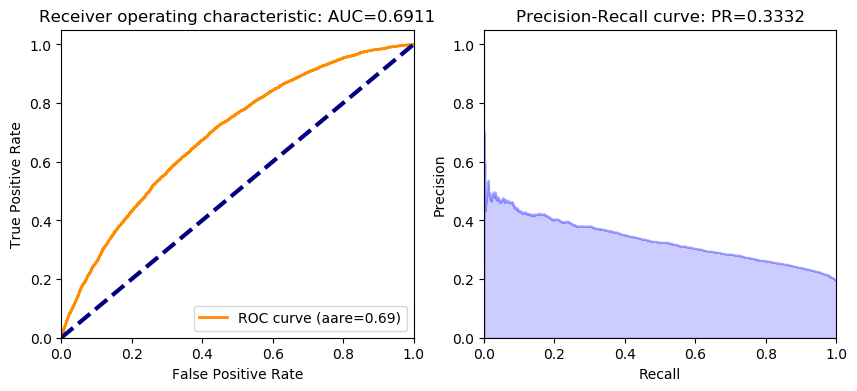

In [162]:
ROC_AUC(gbm_v7,test_hex7,'loan_default')

The best model for GBM is GBM with random undersampling, with sampling_strategy=0.5, ntrees=300, max_depth=5, learning_rate=0.05 and min_rows=10. The lift score is 2.08, the ROC AUC is 0.6911 and the PR AUC is 0.3332.

### Deep Learning with Keras  <a class="anchor" id="4"></a>

In [163]:
from sklearn.model_selection import train_test_split
#split train test dataset to 70%/30%
X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(labels=['loan_default'], axis=1),
    df1['loan_default'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((56000, 76), (24000, 76))

In [164]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
scaler.fit(X_train)
X_train_s=scaler.transform(X_train)
X_test_s=scaler.transform(X_test)

#### model 1 <a class="anchor" id="4.1"></a>

In [177]:
from keras.models import Sequential
from keras.layers import Dense, Activation 
from numpy.random import seed
seed(1)

model1 = Sequential()
model1.add(Dense(50,activation='relu', input_dim=76)) 
model1.add(Dense(30,activation='relu'))
model1.add(Dense(20,activation='relu'))
model1.add(Dense(10,activation='relu'))
model1.add(Dense(5,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1.fit(X_train_s, y_train, epochs=10, batch_size=500,verbose=0)

In [258]:
#gains table 
def gains_table(model):
    df_prep = pd.DataFrame(columns = ['actual','pred'])
    df_prep['actual'] = y_test
    df_prep['pred'] =model.predict_proba(X_test_s)
    df_prep = df_prep.sort_values(by='pred',ascending=False)
    df_prep['row_id'] = range(0,0+len(df_prep))
    df_prep['decile'] = (df_prep['row_id'] / (len(df_prep)/10)).astype(int)
    df_prep.loc[df_prep['decile'] == 10] =9
    gains = df_prep.groupby('decile')['actual'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual']  ) * 100 
    gains['gain'] = (gains['cum_actual'] / gains['cum_count']*100).round(2)
    return gains

In [179]:
gains_table(model1)

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,941,1459,2400,941,1459,0.20,0.08,459.7,2.05,12.0,39.21
1,2400,706,1694,4800,1647,3153,0.36,0.16,919.4,1.79,20.0,34.31
2,2400,664,1736,7200,2311,4889,0.50,0.25,1379.1,1.68,25.0,32.10
3,2400,529,1871,9600,2840,6760,0.62,0.35,1838.8,1.54,27.0,29.58
4,2400,468,1932,12000,3308,8692,0.72,0.45,2298.5,1.44,27.0,27.57
5,2400,416,1984,14400,3724,10676,0.81,0.55,2758.2,1.35,26.0,25.86
6,2400,334,2066,16800,4058,12742,0.88,0.66,3217.9,1.26,22.0,24.15
7,2400,238,2162,19200,4296,14904,0.93,0.77,3677.6,1.17,16.0,22.38
8,2400,188,2212,21600,4484,17116,0.98,0.88,4137.3,1.08,10.0,20.76


In [180]:
def ROC_AUC(model):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = y_test
    y_pred = model.predict_proba(X_test_s)
#     print(y_pred[['p1']])
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()


   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



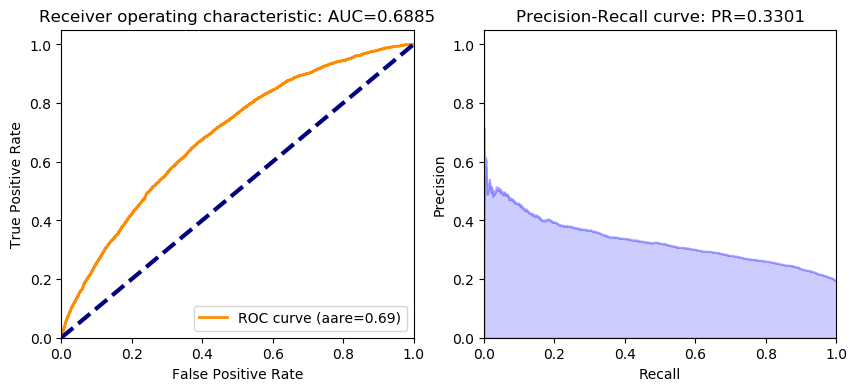

In [181]:
ROC_AUC(model1)

#### model 2 <a class="anchor" id="4.2"></a>

In [250]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from numpy.random import seed
seed(1)

model2 = Sequential()

model2.add(Dense(200,activation='relu', input_dim=76)) 
model2.add(Dense(100,activation='relu'))
model2.add(Dense(50,activation='relu'))
model2.add(Dense(30,activation='relu'))
model2.add(Dense(20,activation='relu'))
model2.add(Dense(10,activation='relu'))
model2.add(Dense(5,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.fit(X_train_s, y_train, epochs=10, batch_size=800,verbose=0)

In [251]:
gains_table(model2)

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,960,1440,2400,960,1440,0.21,0.07,459.7,2.09,14.0,40.00
1,2400,684,1716,4800,1644,3156,0.36,0.16,919.4,1.79,20.0,34.25
2,2400,642,1758,7200,2286,4914,0.50,0.25,1379.1,1.66,25.0,31.75
3,2400,570,1830,9600,2856,6744,0.62,0.35,1838.8,1.55,27.0,29.75
4,2400,480,1920,12000,3336,8664,0.73,0.45,2298.5,1.45,28.0,27.80
5,2400,377,2023,14400,3713,10687,0.81,0.55,2758.2,1.35,26.0,25.78
6,2400,332,2068,16800,4045,12755,0.88,0.66,3217.9,1.26,22.0,24.08
7,2400,241,2159,19200,4286,14914,0.93,0.77,3677.6,1.17,16.0,22.32
8,2400,195,2205,21600,4481,17119,0.97,0.88,4137.3,1.08,9.0,20.75



   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



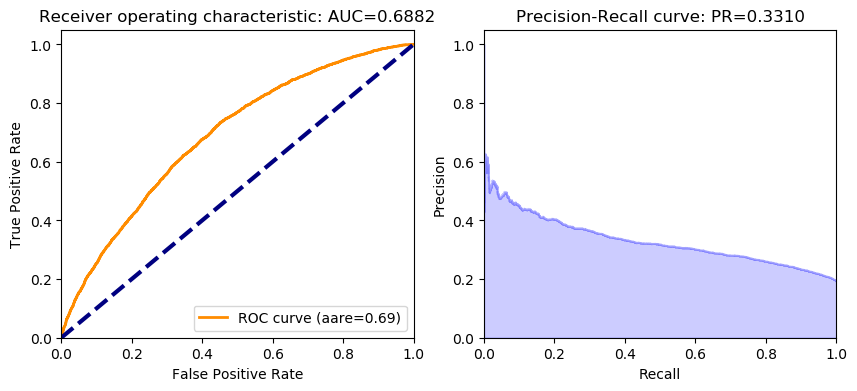

In [252]:
ROC_AUC(model2)

#### model 3 <a class="anchor" id="4.3"></a>

In [255]:
from keras.models import Sequential
from keras.layers import Dense, Activation 
from numpy.random import seed
seed(1)

model3 = Sequential()
model3.add(Dense(100,activation='relu', input_dim=76)) 
model3.add(Dense(80,activation='relu'))
model3.add(Dense(60,activation='relu'))
model3.add(Dense(40,activation='relu'))
model3.add(Dense(20,activation='relu'))
model3.add(Dense(10,activation='relu'))
model3.add(Dense(5,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model3.fit(X_train_s, y_train, epochs=10, batch_size=800,verbose=0)

In [256]:
gains_table(model3)

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,950,1450,2400,950,1450,0.21,0.07,459.7,2.07,14.0,39.58
1,2400,714,1686,4800,1664,3136,0.36,0.16,919.4,1.81,20.0,34.67
2,2400,632,1768,7200,2296,4904,0.50,0.25,1379.1,1.66,25.0,31.89
3,2400,545,1855,9600,2841,6759,0.62,0.35,1838.8,1.55,27.0,29.59
4,2400,463,1937,12000,3304,8696,0.72,0.45,2298.5,1.44,27.0,27.53
5,2400,405,1995,14400,3709,10691,0.81,0.55,2758.2,1.34,26.0,25.76
6,2400,326,2074,16800,4035,12765,0.88,0.66,3217.9,1.25,22.0,24.02
7,2400,247,2153,19200,4282,14918,0.93,0.77,3677.6,1.16,16.0,22.30
8,2400,193,2207,21600,4475,17125,0.97,0.88,4137.3,1.08,9.0,20.72



   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



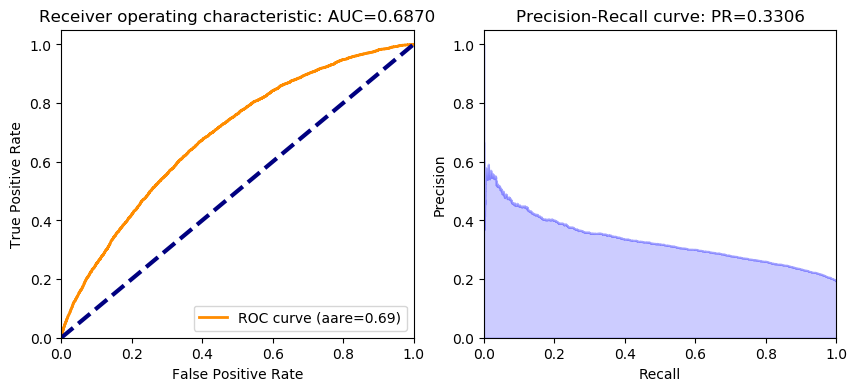

In [257]:
ROC_AUC(model3)

#### model 4 <a class="anchor" id="4.4"></a>

In [227]:
from keras.models import Sequential
from keras.layers import Dense, Activation 
from numpy.random import seed
seed(1)

model4 = Sequential()
model4.add(Dense(200,activation='relu', input_dim=76)) 
model4.add(Dense(100,activation='relu')) 
model4.add(Dense(50,activation='relu'))
model4.add(Dense(30,activation='relu'))
model4.add(Dense(20,activation='relu'))
model4.add(Dense(5,activation='relu'))
model4.add(Dense(1,activation='sigmoid'))

model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model4.fit(X_train_s, y_train, epochs=10, batch_size=800,verbose=0)

In [228]:
gains_table(model4)

,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,2400,937,1463,2400,937,1463,0.20,0.08,459.7,2.04,12.0,39.04
1,2400,710,1690,4800,1647,3153,0.36,0.16,919.4,1.79,20.0,34.31
2,2400,651,1749,7200,2298,4902,0.50,0.25,1379.1,1.67,25.0,31.92
3,2400,527,1873,9600,2825,6775,0.61,0.35,1838.8,1.54,26.0,29.43
4,2400,482,1918,12000,3307,8693,0.72,0.45,2298.5,1.44,27.0,27.56
5,2400,381,2019,14400,3688,10712,0.80,0.55,2758.2,1.34,25.0,25.61
6,2400,327,2073,16800,4015,12785,0.87,0.66,3217.9,1.25,21.0,23.90
7,2400,269,2131,19200,4284,14916,0.93,0.77,3677.6,1.16,16.0,22.31
8,2400,197,2203,21600,4481,17119,0.97,0.88,4137.3,1.08,9.0,20.75



   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



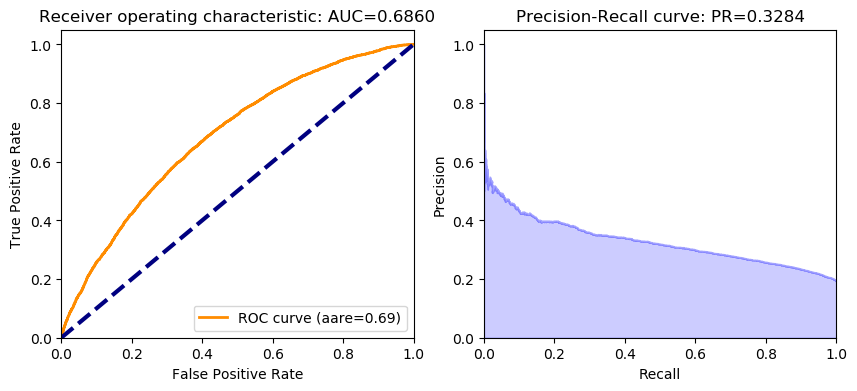

In [210]:
ROC_AUC(model4)

The best model for deep learning is model 2, with 6 hidden layers, activation='relu', no dropout, epochs=10 and batch_size=800. The lift score is 2.09, the ROC AUC is 0.688 and the PR AUC is 0.331.